<a href="https://colab.research.google.com/github/kdm1258/self_studying_ML_DL/blob/main/7_3_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 손실 곡선

손실 곡선(Loss Curve)은 머신러닝 모델의 훈련 과정에서 손실 함수의 값이 어떻게 변하는지를 보여주는 그래프이다. 일반적으로 훈련 손실(Training Loss)과 검증 손실(Validation Loss)을 동시에 표시하여 모델이 과적합(overfitting)되는지 여부를 판단하는 데 사용한다.

fit() 메서드로 모델 훈련을 했을 때 마지막에 다음과 같은 메시지를 보았을 것이다.

<keras.src.callbacks.history.History at 0x7d10b8dc7790>

이는 fit() 메서드가 무언갈 반환한다는 뜻이다. 실제로 fit() 메서드는 History 클래스 객체를 반환하는데 History 객체에는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# 모델을 만드는 간단한 함수 정의

def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape = (28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

In [ ]:
model = model_fn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#verbose = 1(default) 진행 막대, 손실 등의 지표
#verbose = 0 훈련과정 생략
#verbose = 2 진행 막대 생략 손실 등의 지표
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


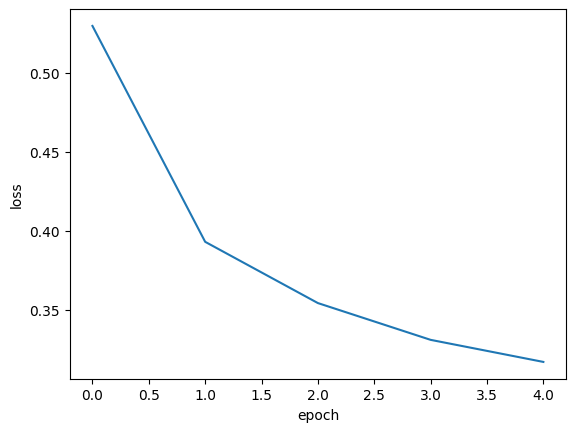

In [ ]:
# loss에 대한 그래프
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

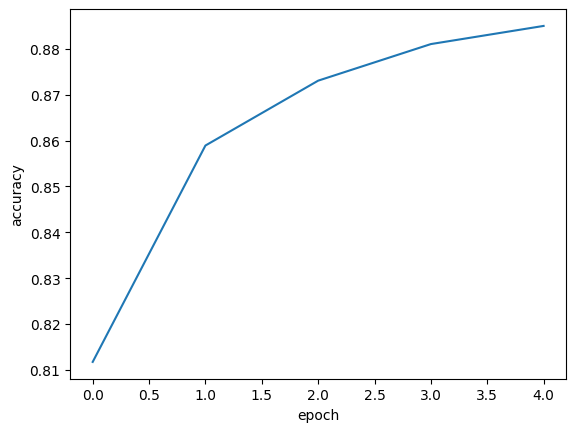

In [ ]:
# accuracy에 대한 그래프
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


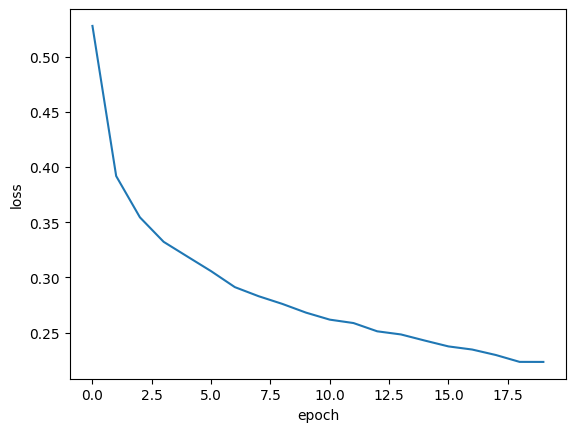

In [ ]:
# 에포크를 20으로 늘린 후 성능 비교
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 에포크에 따른 과대적합과 과소적합을 파악해야한다. 에포크를 20으로 늘렸을 때 loss는 감소했지만 과대적합의 위험이 있기 때문이다.

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련세트에 대한 점수 뿐만아니라 검증세트에 대한 점수도 필요하다.

In [ ]:
# 에포크마다 검증 손실을 계산하기 위해서는 fit() 메서드에 검증 데이터를 전달하면된다.
# 이때 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달한다.
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


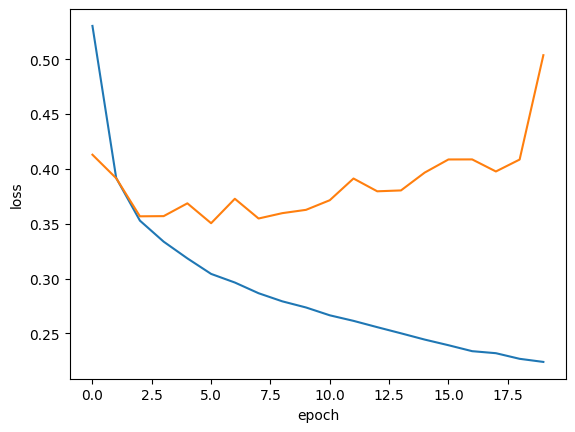

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

초기에 검증 손실이 감소하다가 5번째 에포크 이후로 다시 증가하는 양상을 띈다.

훈련 데이터의 경우 당연히 에포크가 증가할수록 loss가 줄어드는데 이는 과대적합에 해당한다.

검증 손실이 증가하는 시점을 최대한 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


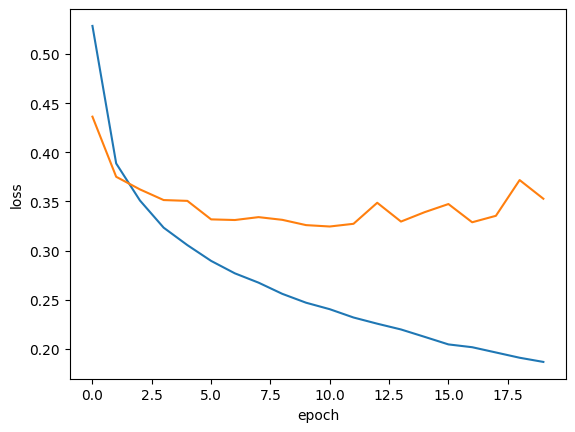

In [ ]:
# 옵티마이저로 adam을 사용해 모델을 만들어보자
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

에포크가 10까지 감소하는 경향을 보임

과대적합이 줄었다고 말할 수 있다.

## 드롭아웃(Drop out)

드롭아웃(Dropout)은 인공 신경망에서 과적합(overfitting)을 방지하기 위해 사용되는 정규화 기법이다. 드롭아웃은 학습 과정 중 일부 뉴런을 무작위로 비활성화하여, 신경망이 특정 패턴이나 노드에 의존하지 않도록 한다. 이렇게 함으로써 모델이 더 일반화된 패턴을 학습할 수 있게 된다.

드롭아웃의 작동 방식은 다음과 같다:

1. 드롭아웃 확률 설정: 드롭아웃 층을 추가할 때 드롭아웃 확률을 설정한다. 예를 들어, 드롭아웃 확률이 0.5인 경우, 학습 중 매번 절반의 뉴런을 비활성화한다.

2. 무작위 뉴런 비활성화: 각 학습 단계마다 지정된 확률에 따라 무작위로 뉴런을 비활성화한다.

3. 활성화 뉴런 스케일링: 학습 후 예측을 수행할 때는 드롭아웃이 적용되지 않지만, 드롭아웃을 적용한 것과 동일한 출력 값을 얻기 위해 활성화된 뉴런의 출력을 스케일링한다.

이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대한 주의를 기울여야한다. 일부 뉴런의 출력이 없을 수도 있다는 것을 감안한다면 더 안정적인 예측을 만들 수 있다.

In [3]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

Dropout 층은 훈련되는 파라미터가 없다.

또한 입력과 출력의 크기가 같다. 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않는다.

검증을 할때에는 드롭아웃 레이어를 제거해주어야 한다. 그러나 keras에서는 알아서 제거를 해주기 때문에 마음편하게 검증을 진행해도 된다.

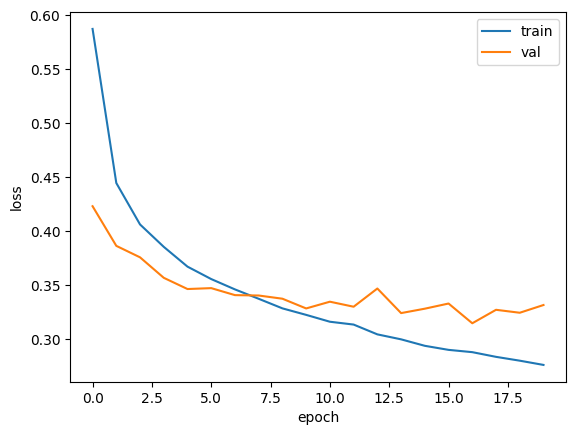

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

열 번째 에포크에서 검증 손실의 감소가 멈추지만 크게 상승하지않고 어느정도 유지되므로 에포크를 10으로 하고 다시 훈련을 실행해보자.

## 모델 저장과 복원

In [4]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

In [5]:
# 모델의 파라미터를 저장하는 메서드 save_weights
# 기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'인 경우 HDF5 포맷으로 저장한다.
model.save_weights('model-weights.weights.h5')

In [6]:
# 모델 구조와 모델 파라미터를 함께 저장하는 메서드 save
# 기본적으로 이 메서드는 텐서플로우의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.
model.save('model-whole.h5')

In [7]:
!ls -al *.h5

-rw-r--r-- 1 root root 976600 Feb 28 06:23 model-weights.weights.h5
-rw-r--r-- 1 root root 978584 Feb 28 06:23 model-whole.h5


In [8]:
# 훈련하지 않은 새로운 모델을 만들고 model-weight.weight.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용하기
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.weights.h5')

In [10]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.8829166666666667


정확도 계산:

(28, 28)의 이미지가 주어졌을 때 prediect() 메서드를 사용하면 각 레이블마다의 확률이 출력된다. 이때 np.argmax()메서드로 최대확률을 가진 label의 인덱스를 가져와 해당 인덱스가 target데이터와 동일한지 비교하여 정확도를 계산한다.

In [26]:
# 훈련하지 않은 모델을 생성하고 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도를 출력
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8853 - loss: 0.3249


[0.32515454292297363, 0.8829166889190674]

## 콜백(call back)

콜백은 훈련과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스이다.

fit() 메서드의ㅣ callbacks 매개변수에 리스트로 전달하여 사용하며, 이번에 사용하는 ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다.

save_best_only = True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.

저장될 파일 이름을 'best-model.h5'로 지정하여 콜백을 적용해보자

In [27]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

# 자동으로 checkpoint_cb에 최고 성능 모델을 callback해준다
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs = 20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8866 - loss: 0.3142


[0.3181127607822418, 0.8859999775886536]

사실 검증 점수는 한번 상승하기 시작하면 그 이후에는 과대적합이 더 커지므로 훈련을 계속 할 필요가 없다. 따라서 훈련을 조기종료시키면 컴퓨터 리소스를 절약할 수 있다.

케라스에는 조기 종료를 위한 **EarlyStopping** 콜백을 제공한다. 이 콜백의 patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다.

예를들어 patience = 2로 지정하면 2번연속 검증 점수가 향상되지 않으면 훈련을 종료한다. 또한 restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.

**EarlyStopping** 콜백을 **ModelCheckpoint** 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [29]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs = 20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
print(early_stopping_cb.stopped_epoch)

15


에포크 횟수가 0부터 시작하므로 15는 16번째 에포크에서 훈련이 중지되었고 patience = 2 이므로 최상의 모델을 14번째 모델일 것이다.

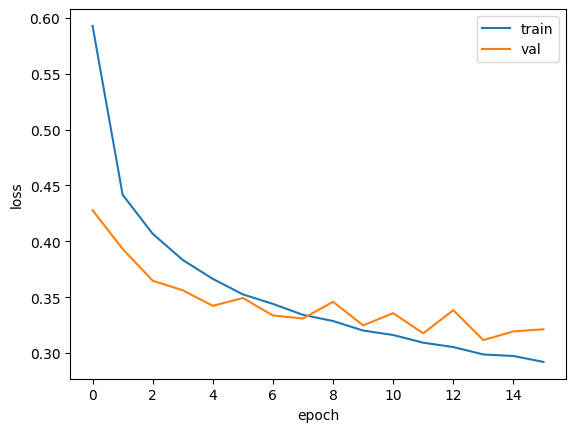

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [37]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8925 - loss: 0.3088


[0.31160399317741394, 0.8879166841506958]

### 왜 ModelCheckpoint와 EarlyStopping을 함께 쓰는 게 좋을까요?
EarlyStopping: 훈련을 조기에 멈추게 하기 때문에, 최종적으로 모델이 훈련을 끝내기 전에 더 이상 개선되지 않으면 멈추게 됩니다. 그러나 이때 모델이 과적합되기 전에 중지되었더라도, 훈련이 진행되면서 성능이 좋았던 중간 상태의 모델이 있을 수 있습니다.

ModelCheckpoint: 훈련 중 성능이 가장 좋았던 모델의 가중치를 저장해 두기 때문에, 최종 훈련이 끝났을 때 또는 EarlyStopping에 의해 훈련이 중단되었을 때에도 가장 좋은 모델을 복원할 수 있습니다.

즉, EarlyStopping이 훈련을 조기에 멈추기 전에 모델이 최고 성능을 보였던 시점의 가중치를 저장할 수 있기 때문에, 최종 모델이 아닌 중간에 성능이 좋았던 모델을 복원할 수 있습니다.